<a href="https://colab.research.google.com/github/fyzhang1/Final_Project/blob/main/Final_transformer_LV_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LV动态系统模型的定义

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from scipy.integrate import solve_ivp
from functools import partial
from statistics import mean

class LotkaVolterraDataset(Dataset):

    def __init__(self, num_traj_per_env, time_horizon, params, dt, batch_t=10, method='RK45', group='train'):
        super().__init__()
        self.num_traj_per_env = num_traj_per_env
        self.num_env = len(params)
        self.len = num_traj_per_env * self.num_env
        self.time_horizon = float(time_horizon)       # total time
        self.dt = dt
        self.batch_t = batch_t

        self.params_eq = params
        self.test = group == 'test'
        self.max = np.iinfo(np.int32).max
        self.buffer = dict()
        self.method = method
        self.indices = [list(range(env * num_traj_per_env, (env + 1) * num_traj_per_env)) for env in range(self.num_env)]

    def _f(self, t, x, env=0):
        alpha = self.params_eq[env]['alpha']
        beta  = self.params_eq[env]['beta' ]
        gamma = self.params_eq[env]['gamma']
        delta = self.params_eq[env]['delta']

        d = np.zeros(2)
        d[0] = alpha * x[0] - beta * x[0] * x[1]
        d[1] = delta * x[0] * x[1] - gamma * x[1]
        return d

    def _get_init_cond(self, index):
        np.random.seed(index if not self.test else self.max-index)
        return np.random.random(2) + 1.

    def __getitem__(self, index):
        env       = index // self.num_traj_per_env
        env_index = index %  self.num_traj_per_env
        t = torch.arange(0, self.time_horizon, self.dt).float()
        t0 = torch.randint(t.size(0) - self.batch_t + 1, (1,)).item()
        if self.buffer.get(index) is None:
            y0 = self._get_init_cond(env_index)

            res = solve_ivp(partial(self._f, env=env), (0., self.time_horizon), y0=y0, method=self.method, t_eval=np.arange(0., self.time_horizon, self.dt))
            res = torch.from_numpy(res.y).float()
            self.buffer[index] = res.numpy()
            return {
                'state'   : res,
                't'       : t,
                'env'     : env,
            }
        else:
            return {
                'state'   : torch.from_numpy(self.buffer[index]),
                't'       : t,
                'env'     : env,
            }

    def __len__(self):
        return self.len

In [ ]:
import copy
from torch.utils.data.sampler import Sampler
import random

class SubsetSequentialSampler(Sampler):
    def __init__(self, indices, mini_batch_size):
        self.mini_batch_size = mini_batch_size
        if not any(isinstance(el, list) for el in indices):
            self.indices = [indices]
        else:
            self.indices = indices
        self.env_len = len(self.indices[0])

    def __iter__(self):
        if len(self.indices) > 1:
            l_indices = copy.deepcopy(self.indices)

            l_iter = list()
            for _ in range(0, self.env_len, self.mini_batch_size):
                for i in range(len(l_indices)):
                    l_iter.extend(l_indices[i][:self.mini_batch_size])
                    del l_indices[i][:self.mini_batch_size]
        else:
            l_iter = copy.deepcopy(self.indices[0])
        return iter(l_iter)

    def __len__(self):
        return sum([len(el) for el in self.indices])

class SubsetRamdomSampler(Sampler):
    def __init__(self, indices, mini_batch_size, same_order_in_groups=True):
        self.mini_batch_size = mini_batch_size
        self.same_order_in_groups = same_order_in_groups
        if not any(isinstance(el, list) for el in indices):
            self.indices = [indices]
        else:
            self.indices = indices
        self.env_len = len(self.indices[0])

    def __iter__(self):
        if len(self.indices) > 1:
            if self.same_order_in_groups:
                l_shuffled = copy.deepcopy(self.indices)
                random.shuffle(l_shuffled[0])
                for i in range(1, len(self.indices)):
                    l_shuffled[i] = [el + i * self.env_len for el in l_shuffled[0]]
            else:
                l_shuffled = copy.deepcopy(self.indices)
                for l in l_shuffled:
                    random.shuffle(l)

            l_iter = list()
            for _ in range(0, self.env_len, self.mini_batch_size):
                for i in range(len(l_shuffled)):
                    l_iter.extend(l_shuffled[i][:self.mini_batch_size])
                    del l_shuffled[i][:self.mini_batch_size]
        else:
            l_shuffled = copy.deepcopy(self.indices[0])
            random.shuffle(l_shuffled)
            l_iter = l_shuffled
        return iter(l_iter)

    def __len__(self):
        return sum([len(el) for el in self.indices])

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from scipy.integrate import solve_ivp
from functools import partial
from statistics import mean
from scipy.stats import ortho_group

class LinearDataset(Dataset):

    def __init__(self, num_traj_per_env, time_horizon, params, dt, method='RK45', group='train'):
        super().__init__()
        self.num_traj_per_env = num_traj_per_env
        self.params_eq = params
        self.num_env = len(params)
        self.dim = len(params[0]['eig_vals'])
        self.len = num_traj_per_env * self.num_env
        self.time_horizon = float(time_horizon)
        self.dt = dt

        np.random.seed(19700101)
        self.mat_ortho = ortho_group.rvs(self.dim)

        self.test = group == 'test'
        self.max = np.iinfo(np.int32).max
        self.buffer = dict()
        self.method = method
        self.indices = [list(range(env * num_traj_per_env, (env + 1) * num_traj_per_env)) for env in range(self.num_env)]

    def _f(self, t, x, env=0):
        eig_vals = np.array(self.params_eq[env]['eig_vals'])
        b = self.params_eq[env].get('b')
        sigma = np.diag(eig_vals)
        deriv = self.mat_ortho.T @ sigma @ self.mat_ortho @ x
        if b is not None:
            deriv += b
        return deriv

    def _get_init_cond(self, index):
        np.random.seed(index if not self.test else self.max-index)
        return np.random.randn(self.dim)

    def __getitem__(self, index):
        env       = index // self.num_traj_per_env
        env_index = index %  self.num_traj_per_env
        t = torch.arange(0, self.time_horizon, self.dt).float()
        if self.buffer.get(index) is None:
            u_0 = self._get_init_cond(env_index)

            res = solve_ivp(partial(self._f, env=env), (0., self.time_horizon), y0=u_0, method=self.method, t_eval=np.arange(0., self.time_horizon, self.dt))
            res_u = torch.from_numpy(res.y).float()

            self.buffer[index] = res_u.numpy()
            return {
                'state'   : res_u,
                't'       : t,
                'env'     : env,
            }
        else:
            return {
                'state'   : torch.from_numpy(self.buffer[index]),
                't'       : t,
                'env'     : env,
            }

    def __len__(self):
        return self.len

In [ ]:
import torch
import math
from torch.utils.data import DataLoader

def param_lv():
    params = [
        {'alpha': 0.5 , 'beta': 0.5, 'gamma': 0.5 , 'delta': 0.5},
        {'alpha': 0.25, 'beta': 0.5, 'gamma': 0.5 , 'delta': 0.5},
        {'alpha': 0.75, 'beta': 0.5, 'gamma': 0.5 , 'delta': 0.5},
        {'alpha': 1.0 , 'beta': 0.5, 'gamma': 0.5 , 'delta': 0.5},
        {'alpha': 0.5 , 'beta': 0.5, 'gamma': 0.25, 'delta': 0.5},
        {'alpha': 0.5 , 'beta': 0.5, 'gamma': 0.75, 'delta': 0.5},
        {'alpha': 0.5 , 'beta': 0.5, 'gamma': 1.0 , 'delta': 0.5},
        {'alpha': 0.25, 'beta': 0.5, 'gamma': 0.25, 'delta': 0.5},
        {'alpha': 0.75, 'beta': 0.5, 'gamma': 0.75, 'delta': 0.5},
        {'alpha': 1.0 , 'beta': 0.5, 'gamma': 1.0 , 'delta': 0.5},
    ]

    n_env = len(params)
    mini_batch_size = 1

    dataset_train_params = {
        'num_traj_per_env': 1,
        'time_horizon': 10,
        'params': params,
        'dt': 0.5,
        'method': 'RK45',
        'group': 'train',
    }

    dataset_test_params = dict()
    dataset_test_params.update(dataset_train_params)
    dataset_test_params['num_traj_per_env'] = 32
    dataset_test_params['group'] = 'test'

    dataset_train = LotkaVolterraDataset(**dataset_train_params)
    dataset_test  = LotkaVolterraDataset(**dataset_test_params)
    sampler_train = SubsetRamdomSampler(indices=dataset_train.indices, mini_batch_size=mini_batch_size)
    sampler_test  = SubsetSequentialSampler(indices=dataset_test.indices , mini_batch_size=1)

    dataloader_train_params = {
        'dataset'    : dataset_train,
        'batch_size' : mini_batch_size * n_env,
        'num_workers': 0,
        'sampler'    : sampler_train,
        'pin_memory' : True,
        'drop_last'  : False,
    }

    dataloader_test_params = {
        'dataset'    : dataset_test,
        'batch_size' : n_env,
        'num_workers': 0,
        'sampler'    : sampler_test,
        'pin_memory' : True,
        'drop_last'  : False,
    }

    dataloader_train = DataLoader(**dataloader_train_params)
    dataloader_test  = DataLoader(**dataloader_test_params)

    return dataloader_train, dataloader_test


def init_dataloaders(dataset, buffer_filepath=None):
    if dataset == 'lv':
        return param_lv()

In [ ]:
train_data, test_data = init_dataloaders('lv')

Train batch keys: dict_keys(['state', 't', 'env'])
Key: state, Shape: torch.Size([10, 2, 20])
Key: t, Shape: torch.Size([10, 20])
Key: env, Shape: torch.Size([10])


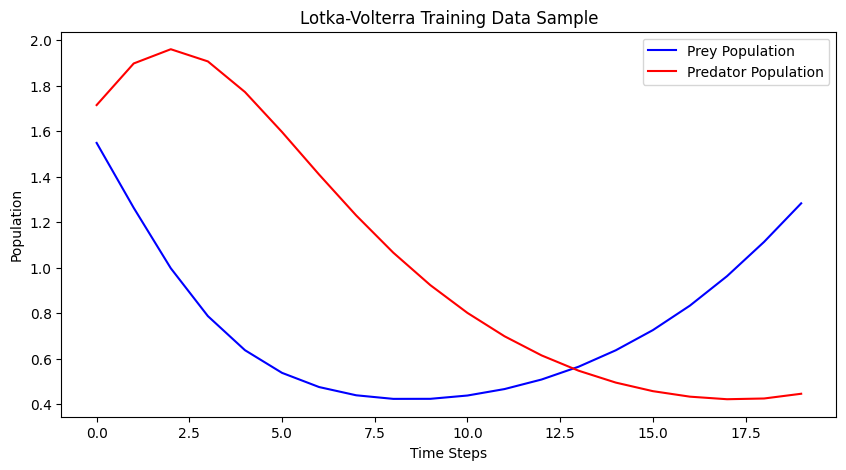

In [ ]:
import matplotlib.pyplot as plt

# 获取一个批次的数据
train_batch = next(iter(train_data))

# 查看 train_batch 的键和值的类型
print("Train batch keys:", train_batch.keys())

# 查看字典中每个键对应的值的形状
for key in train_batch:
    print(f"Key: {key}, Shape: {train_batch[key].shape}")

# 使用 'state' 键提取输入数据
input_data = train_batch['state']  # 输入数据，形状为 [batch_size, seq_len, feature_dim]

# 'state' 的形状为 [batch_size, feature_dim, seq_len]，需要调整顺序以便绘图
input_data = input_data.permute(0, 2, 1)  # 变为 [batch_size, seq_len, feature_dim]

# 选择一个样本进行可视化（例如，选择第一个样本）
sample_index = 0
time_steps = range(input_data.shape[1])

# 提取捕食者和被捕食者数量
prey_population = input_data[sample_index, :, 0].numpy()  # 被捕食者
predator_population = input_data[sample_index, :, 1].numpy()  # 捕食者

# 可视化捕食者和被捕食者的数量
plt.figure(figsize=(10, 5))
plt.plot(time_steps, prey_population, label="Prey Population", color='blue')
plt.plot(time_steps, predator_population, label="Predator Population", color='red')

plt.xlabel('Time Steps')
plt.ylabel('Population')
plt.title('Lotka-Volterra Training Data Sample')
plt.legend()
plt.show()


# Transformer Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# 3. 定义 Transformer 模型
class Configs:
    def __init__(self):
        self.label_len = 10
        self.pred_len = 1
        self.enc_in = 2  # 输入特征维度
        self.dec_in = 2  # 解码器输入特征维度
        self.d_model = 64
        self.e_layers = 2  # 编码器层数
        self.d_layers = 1  # 解码器层数
        self.n_heads = 4  # 注意力头数
        self.d_ff = 128  # FeedForward 层维度
        self.dropout = 0.1
        self.activation = "gelu"
        self.output_attention = False
        self.rev = False
        self.c_out = 2  # 输出维度

class DataEmbedding(nn.Module):
    def __init__(self, input_dim, d_model, dropout):
        super(DataEmbedding, self).__init__()
        self.value_embedding = nn.Linear(input_dim, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark=None):
        x = self.value_embedding(x) + self.position_embedding[:, :x.size(1), :]
        return self.dropout(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.self_attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, e_layers, n_heads, d_model, d_ff, dropout, activation, output_attention, norm_layer=None):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(e_layers)])

    def forward(self, x, attn_mask=None):
        for layer in self.layers:
            x = layer(x)
        return x, None

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out):
        self_attn_output, _ = self.self_attention(x, x, x)
        x = self.norm1(x + self.dropout(self_attn_output))
        cross_attn_output, _ = self.cross_attention(x, enc_out, enc_out)
        x = self.norm2(x + self.dropout(cross_attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Decoder(nn.Module):
    def __init__(self, d_layers, n_heads, d_model, d_ff, dropout, activation, output_attention, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(d_layers)])

    def forward(self, x, enc_out, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, enc_out)
        return x

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Embedding
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.dropout)
        self.dec_embedding = DataEmbedding(configs.dec_in, configs.d_model, configs.dropout)

        # Encoder
        self.encoder = Encoder(
            configs.e_layers, configs.n_heads, configs.d_model, configs.d_ff,
            configs.dropout, configs.activation, configs.output_attention,
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )

        # Decoder
        self.decoder = Decoder(
            configs.d_layers, configs.n_heads, configs.d_model, configs.d_ff,
            configs.dropout, configs.activation, configs.output_attention,
            norm_layer=torch.nn.LayerNorm(configs.d_model),
        )
        self.projection = nn.Linear(configs.d_model, configs.c_out)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)

        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

# Training

In [ ]:
# 4. 训练 Transformer 模型来拟合 LV 系统的时间序列数据
configs = Configs()
model = Model(configs)

# 初始化优化器和损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1000

In [ ]:
# 训练模型
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_rmse = 0.0
    num_batches = len(train_data)

    for batch in train_data:
        # 提取 'state' 作为输入数据
        input_data = batch['state'].permute(0, 2, 1)  # 调整形状为 [batch_size, seq_len, feature_dim]
        target_data = input_data[:, -1, :]  # 使用最后一个时间步作为目标

        optimizer.zero_grad()

        # 前向传播
        output = model(input_data, None, input_data, None).squeeze()

        # 计算损失
        loss = criterion(output, target_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 计算 RMSE
        rmse = torch.sqrt(torch.mean((output - target_data) ** 2))
        total_rmse += rmse.item()

    avg_loss = total_loss / num_batches
    avg_rmse = total_rmse / num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, RMSE: {avg_rmse:.4f}")

Epoch [1/1000], Loss: 1.9310, RMSE: 1.3896
Epoch [2/1000], Loss: 1.0212, RMSE: 1.0105
Epoch [3/1000], Loss: 0.8545, RMSE: 0.9244
Epoch [4/1000], Loss: 0.7250, RMSE: 0.8515
Epoch [5/1000], Loss: 0.7268, RMSE: 0.8525
Epoch [6/1000], Loss: 0.6018, RMSE: 0.7758
Epoch [7/1000], Loss: 0.5347, RMSE: 0.7312
Epoch [8/1000], Loss: 0.3550, RMSE: 0.5958
Epoch [9/1000], Loss: 0.3685, RMSE: 0.6070
Epoch [10/1000], Loss: 0.2755, RMSE: 0.5249
Epoch [11/1000], Loss: 0.3751, RMSE: 0.6124
Epoch [12/1000], Loss: 0.3441, RMSE: 0.5866
Epoch [13/1000], Loss: 0.2658, RMSE: 0.5156
Epoch [14/1000], Loss: 0.1941, RMSE: 0.4406
Epoch [15/1000], Loss: 0.1616, RMSE: 0.4020
Epoch [16/1000], Loss: 0.1263, RMSE: 0.3554
Epoch [17/1000], Loss: 0.1156, RMSE: 0.3401
Epoch [18/1000], Loss: 0.1613, RMSE: 0.4016
Epoch [19/1000], Loss: 0.1423, RMSE: 0.3773
Epoch [20/1000], Loss: 0.1897, RMSE: 0.4356
Epoch [21/1000], Loss: 0.0969, RMSE: 0.3113
Epoch [22/1000], Loss: 0.1472, RMSE: 0.3837
Epoch [23/1000], Loss: 0.0837, RMSE: 0.28

In [ ]:
model.eval()
total_rmse = 0.0
num_batches = len(test_data)

with torch.no_grad():
    for batch in test_data:
        input_data = batch['state'].permute(0, 2, 1)  # 调整形状为 [batch_size, seq_len, feature_dim]
        target_data = input_data[:, -1, :]  # 使用最后一个时间步作为目标

        # 前向传播
        output = model(input_data, None, input_data, None).squeeze()

        # 计算 RMSE
        rmse = torch.sqrt(torch.mean((output - target_data) ** 2))
        total_rmse += rmse.item()

avg_rmse = total_rmse / num_batches
print(f"Test RMSE: {avg_rmse:.4f}")

Test RMSE: 0.1285


# 测试

In [ ]:
import numpy as np

# Define the model parameters
omega = 1
b = 0.5

# Generate the dataset S
T = 10
S = [(i, np.sin(omega * i + b)) for i in range(T)]

# Generate the test data x[t] for an arbitrary t
t = 7
x_t = np.sin(omega * t + b)

# Perform the different interpolation and extrapolation methods
print(f"In-domain interpolation: (omega, b) = (omega*, b*) and t ∈ [{min(x[0] for x in S)}, {max(x[0] for x in S)}]")
print(f"In-domain extrapolation: (omega, b) = (omega*, b*) and t ∉ [{min(x[0] for x in S)}, {max(x[0] for x in S)}]")
print(f"Out-of-domain interpolation: (omega, b) ≠ (omega*, b*) and t ∈ [{min(x[0] for x in S)}, {max(x[0] for x in S)}]")
print(f"Out-of-domain extrapolation: (omega, b) ≠ (omega*, b*) and t ∉ [{min(x[0] for x in S)}, {max(x[0] for x in S)}]")

print(f"\nThe test data x[{t}] = {x_t:.2f}")

In-domain interpolation: (omega, b) = (omega*, b*) and t ∈ [0, 9]
In-domain extrapolation: (omega, b) = (omega*, b*) and t ∉ [0, 9]
Out-of-domain interpolation: (omega, b) ≠ (omega*, b*) and t ∈ [0, 9]
Out-of-domain extrapolation: (omega, b) ≠ (omega*, b*) and t ∉ [0, 9]

The test data x[7] = 0.94


In [ ]:
# Convert data to tensors, but now with two features
# For this example, the second feature will just be a constant (e.g., zero)
x_enc = torch.tensor([[x[0], 0] for x in S], dtype=torch.float32).view(-1, 1, 2)  # Encoder input with 2 features
y = torch.tensor([x[1] for x in S], dtype=torch.float32).view(-1, 1)  # Target sine values         # Target sine values

# Time-mark encoding (if needed for position embedding, here just using a range)
x_mark_enc = torch.arange(T).float().view(-1, 1)  # Example time-mark for encoder
x_mark_dec = x_mark_enc  # Decoder time-mark can be the same (you might adjust this later)

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    # Here, for simplicity, using the same data for both encoder and decoder
    # Normally, decoder input would differ (for example, using the previous time steps as input)
    x_dec = x_enc  # Decoder input (in this case, same as encoder input)

    # Forward pass
    optimizer.zero_grad()
    output = model(x_enc, x_mark_enc, x_dec, x_mark_dec)  # Forward pass through the model

    # Compute loss
    loss = criterion(output.squeeze(), y)  # Squeeze to remove unnecessary dimensions
    loss.backward()  # Backward pass
    optimizer.step()  # Optimizer step

    total_loss += loss.item()

    avg_loss = total_loss
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/1000], Loss: 1.3174
Epoch [2/1000], Loss: 0.3911
Epoch [3/1000], Loss: 0.6031
Epoch [4/1000], Loss: 0.5784
Epoch [5/1000], Loss: 0.5728
Epoch [6/1000], Loss: 0.4065
Epoch [7/1000], Loss: 0.3429
Epoch [8/1000], Loss: 0.4135
Epoch [9/1000], Loss: 0.4905
Epoch [10/1000], Loss: 0.4355
Epoch [11/1000], Loss: 0.5285
Epoch [12/1000], Loss: 0.4377
Epoch [13/1000], Loss: 0.4468
Epoch [14/1000], Loss: 0.3897
Epoch [15/1000], Loss: 0.4645
Epoch [16/1000], Loss: 0.4588
Epoch [17/1000], Loss: 0.4948
Epoch [18/1000], Loss: 0.4193
Epoch [19/1000], Loss: 0.4236
Epoch [20/1000], Loss: 0.3715
Epoch [21/1000], Loss: 0.3552
Epoch [22/1000], Loss: 0.4852
Epoch [23/1000], Loss: 0.4352
Epoch [24/1000], Loss: 0.3071
Epoch [25/1000], Loss: 0.3484
Epoch [26/1000], Loss: 0.3890
Epoch [27/1000], Loss: 0.4322
Epoch [28/1000], Loss: 0.4415
Epoch [29/1000], Loss: 0.3819
Epoch [30/1000], Loss: 0.3557
Epoch [31/1000], Loss: 0.4514
Epoch [32/1000], Loss: 0.4059
Epoch [33/1000], Loss: 0.4104
Epoch [34/1000], Lo